# CLasificación de Imágenes usando CNNs

In [ ]:
#Creando la Red desde 0
#Data Augmentation
#Trasnferencia de Aprendizaje

In [ ]:
#Otra práctica: IMAGENET 
#Otra otra práctica: Red Coco

### Importamos las librerías necesarias

In [5]:
import os

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset 
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil

### Configurando los metaoarpametros para trabajar con la red y estableciendo las semillasde los valores aleatorios

In [6]:
lr = 0.001 # learning_rate
batch_size = 10 # mini batches
epochs = 10 # épocas de entrenamiento

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

## Preparando los datos con los que se va a trabajar

In [4]:
os.makedirs('../Práctica 1/data', exist_ok=True)

In [5]:
import splitfolders

In [6]:
splitfolders.ratio('../Práctica 1/data/input', output="../Práctica 1/data/output", seed=1, ratio=(.8, 0.1,0.1), group_prefix=2)


Copying files: 504 files [00:01, 321.31 files/s]


In [7]:
#Buscar función para sacar los archivos de los subfolders

In [8]:
train_dir = '../Práctica 1/data/output/train'
test_dir = '../Práctica 1/data/output/test'
val_dir = '../Práctica 1/data/output/val'

In [9]:
import glob

train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
val_list = glob.glob(os.path.join(val_dir, '*.jpg'))

In [10]:
len(train_list)

397

In [11]:
len(test_list)

52

In [12]:
len(val_list)

49

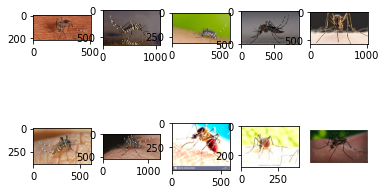

In [13]:
from PIL import Image
random_idx = np.random.randint(1,len(train_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [14]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((256, 256)),
     transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [15]:
train_list[0].split('/')[-1].split('\\')[-1].split('_')[0]

'aegypti'

In [16]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('\\')[-1].split('_')[0]
        if label == 'aegypti':
            label=1
        elif label == 'albopictus':
            label=0
            
        return img_transformed,label

In [17]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [18]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader))


397 40


In [20]:
print(len(val_data), len(val_loader))


49 5


In [21]:
train_data[0][0].shape


torch.Size([3, 256, 256])

In [22]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [29]:
optimizer = optim.SGD(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
#CNN CON RELU MAX SIG/ENTRXBIN
#SGD
#Modificar parámetro y meta (forma sistematica de abordar problema)

In [30]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.7157142162322998, train loss : 0.5397223234176636
Epoch : 1, val_accuracy : 0.6288889050483704, val_loss : 0.7769386172294617
Epoch : 2, train accuracy : 0.6553570628166199, train loss : 0.6106594204902649
Epoch : 2, val_accuracy : 0.6755555272102356, val_loss : 0.6698654294013977
Epoch : 3, train accuracy : 0.6303569674491882, train loss : 0.5922756195068359
Epoch : 3, val_accuracy : 0.6155555844306946, val_loss : 0.7035687565803528
Epoch : 4, train accuracy : 0.6503570675849915, train loss : 0.5999142527580261
Epoch : 4, val_accuracy : 0.6511111259460449, val_loss : 0.6492518186569214
Epoch : 5, train accuracy : 0.6592857241630554, train loss : 0.6121940612792969
Epoch : 5, val_accuracy : 0.6755555868148804, val_loss : 0.6767752170562744
Epoch : 6, train accuracy : 0.6482142210006714, train loss : 0.6374727487564087
Epoch : 6, val_accuracy : 0.5911111235618591, val_loss : 0.7223424911499023
Epoch : 7, train accuracy : 0.6539285182952881, train loss : 0.6

#### El entrenamiento no es de lo más optimo, pero podemos mejorarlo usando otros métodos

#### Usaremos los archivos xml de las imágenes para poder trabajar

In [ ]:
#to do, adaptarlo a los xml de los mosquitos

def leer_annotations(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}
 
        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
 
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
 
        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels